In [120]:
%load_ext autoreload
%autoreload 2




        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

np.random.seed(13)
torch.manual_seed(13)

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will be trained with", device)



The model will be trained with cuda


In [122]:

from environments.SnowmanEnvironment import SnowmanEnvironment

map_rows=9
map_cols=11
n_actions = 4 #Modifica quan implementi gym
map_layers = 1

snowman_env = SnowmanEnvironment(map_file='./Dades/facils/david-1.txt', 
                                 n=map_rows, m=map_cols, 
                                 stop_when_error=False, 
                                 stop_when_dumb=False, 
                                 enable_step_back_optimzation=True, 
                                 enable_blocked_snowman_optimization=True)


In [123]:
from utils.ReplayMemory import ReplayMemory
from utils.ReplayMemory import Transition

memory = ReplayMemory(10000)


In [124]:
from neuralNests.ConvNet_v1 import DQN
policy_net = DQN(map_layers, n_actions, map_rows, map_cols).to(device)
target_net = DQN(map_layers, n_actions, map_rows, map_cols).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [125]:

from trainingAgents.SnowmanTrainingAgent import TrainingAgent

BATCH_SIZE = 256 #mida del batch del replay
GAMMA = 0.99 #factor de descompte de les recompeses futures
EPS_START = 1 #valor inicial de la epsilon per la epsilon greedy policy
EPS_END = 0.05 #valor final de la epsilon per la epsilon greedy policy
EPS_DECAY = 1000000 #controla la caiguda expoencial del valor epsilon, com més alt, mes lent disminueix
TAU = 0.005 #controla cada quan s'actualitza la target network
LR = 1e-3 #Learning rate de l'optimitzador


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
training_agent = TrainingAgent(policy_net, target_net, optimizer, memory, EPS_END, EPS_START, EPS_DECAY, GAMMA, BATCH_SIZE, device)



In [126]:

print("***************************ENCODED MAP****************************")
snowman_env.show_map(SnowmanEnvironment.ENCODED_TEXT_MODE)
print("\n")
print("***************************DECODED MAP****************************")
snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
print("\n")

***************************ENCODED MAP****************************
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  4.  9.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  2.  9.  0.  0.]
 [ 0.  0.  9.  9.  9. 10.  9.  7.  9.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  1.  9.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  9.  9.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


***************************DECODED MAP****************************
[['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '4' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '2' '.' '#' '#']
 ['#' '#' '.' '.' '.' 'p' '.' '7' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '1' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']]




MAIN TRAINING LOOP

In [127]:
episodes=20000
jugades=50
rewards = []
best_score = -100000
tau_mode = False


for episode in range(episodes):
    state, info = snowman_env.reset()
    #Convertim l'estat a un tensor. Fem unsqueeze perquè la xarxa neuronal s'espera un batch de mapes, i state es un sol mapa.
    #Per tant li passem un batch de un sol mapa encapsulant en un array (o tensor)

    #Separem les capes de l'estat (mapa) en una capa per cada tipus de casella:
    #state = snowman_env.split_map_layers(state)

    state = torch.tensor([state], dtype=torch.float32, device=device).unsqueeze(0)
    act_rewards = []
    nJuagades = 0
    for jugada in range(jugades):
        nJuagades = nJuagades+1
        #Triem una accio segons la politica epsilon greedy
        action = training_agent.select_action_epsilon_greedy(state, snowman_env)
        next_state, reward, done, _ = snowman_env.step(action.item())
        act_rewards.append(reward)
        if reward >= best_score: # Not shown
            best_score = reward # Not shown

        #Conevrtim el reward a un tensor i el seguent state a un tensor, aixi ho guardem al replay_memory tot en tensors:
        reward = torch.tensor([reward], device=device)
        if done:
            next_state = None
        else:
            #next_state = torch.tensor(snowman_env.split_map_layers(next_state), dtype=torch.float32, device=device).unsqueeze(0)
            next_state = torch.tensor([next_state], dtype=torch.float32, device=device).unsqueeze(0)

        
        training_agent.replay_memory.push(state,action, next_state, reward)

        #Anem al seguent estat
        state = next_state

        #OPTIMIZATION
        training_agent.training_step()
        


        #Soft update: Quan actualitzem els pesos, actualitzem el TAU % del pes enlloc de 
        #copiar totalment el pes de cada parametre per evitar variacions massives i millorar la estabilitat:
        target_net_state_dict = training_agent.target_net.state_dict()
        policy_net_state_dict = training_agent.policy_net.state_dict()

        #per tant iterem per cada pes de la xarxa que volem actualitzar, i fem que el seu pes sigui un cert
        # percentatge (TAU) de la xarxa objectiu més el restant (1-TAU) de la seva pròpia. Si TAU és 0.01,
        #copia el 1% del pes de l'objectiu i conserva l'altre 99%
        if tau_mode:
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                training_agent.target_net.load_state_dict(target_net_state_dict)
        else:
            if episode % 50 == 0:
                training_agent.target_net.load_state_dict(training_agent.policy_net.state_dict())
        
        #print("epsilon: ",EPS_END + (EPS_START - EPS_END) * math.exp(-1. * training_agent.steps_done / EPS_DECAY))
        #print("reward", reward.item())
        #snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
        if done:
            break
    rewards.append(sum(act_rewards))
    if episode % 100 == 0:
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * training_agent.steps_done / EPS_DECAY)
        print("\rEpisode: {}, jugades {}, total_score: {} , score: {}, best_score: {} eps: {:.3f}    \n".format(episode, nJuagades, sum(act_rewards), act_rewards, best_score, eps), end="")
        snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)

            



Episode: 0, jugades 50, total_score: -1682 , score: [1, 1, 1, 1, -9, -100, -9, -100, -50, 1, -100, 1, -9, 1, 1, -9, -50, -9, -9, -50, 1, 1, -9, -100, 1, -50, -100, -50, -9, -100, -100, 1, 20, -9, -100, -100, -100, 1, -9, -9, -100, -100, -100, -9, -100, 1, 20, 1, 1, 20], best_score: 20 eps: 1.000    
[['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '4' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' 'q' '4' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '7' '.' '#' '#']
 ['#' '#' '.' '.' '.' '4' ',' ',' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']]


Episode: 100, jugades 50, total_score: -940 , score: [1, 1, 1, -9, -9, -9, 1, 1, 1, 1, -9, 1, 1, 1, 1, 1, 20, 1, -100, 1, -100, -9, -100, 1, -9, 1, -100, -100, -9, 1, 1, 1, 1, 1, 1, -9, 1, 1, -100, 1, -9, 1, 1, -100, -100, -100, 1, 1, 1, -9], best_score: 30 eps: 0.995    
[['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '4' '.' '#' '#']
 ['#' '#' '.' 'p' '.' '.' '.' '2' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '7' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' ',' '2' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']]
Episode: 200, jugades 50, total_score: -717 , score: [1, 1, -9, -9, 1, 1, -9, -9, 20, -100, 1, 1, 1, 1, 1, 1, 1, 1, -9, 1, 1, 1, -100, -9, -9, 1, 1, 1, 1, -9, -9, -9, 1, -9, 1, 1, 1, -100, -9, -9, -100, -9, 1, 1, -100, -9, -9, -100, -9, -9], best_score: 30 eps: 0.991    
[['#' '#' '#' '#' '#' '#' '#' '

KeyboardInterrupt: 

MOSTREM ELS RESULTATS (REWARDS)

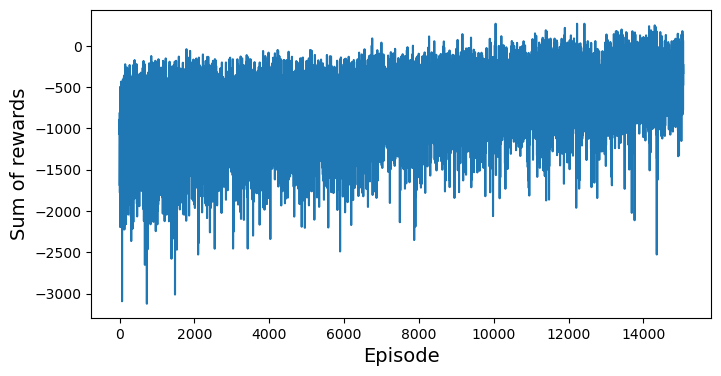

In [128]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
#save_fig("dqn_rewards_plot")
plt.show()

In [ ]:
snowman_env.show_map(SnowmanEnvironment.ENCODED_TEXT_MODE)
snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  4.  9.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  2.  9.  0.  0.]
 [ 0.  0.  9.  9. 10.  9.  9.  7.  9.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  1.  9.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  9.  9.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '4' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '2' '.' '#' '#']
 ['#' '#' '.' '.' 'p' '.' '.' '7' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '1' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']]


In [ ]:
"""
snowman_env_test = SnowmanEnvironment(map_file='./Dades/facils/david-1.txt', 
                                 n=9, m=9, 
                                 stop_when_error=True, 
                                 stop_when_dumb=True, 
                                 enable_step_back_optimzation=True, 
                                 enable_blocked_snowman_optimization=True)
print(snowman_env_test.agent_position)
snowman_env_test.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
snowman_env_test.previous_agent_position = (4,4)
snowman_env_test.agent_position = (4,3)
a = snowman_env_test.adjust_reward(0,(4,4),[4,4],[3,4])
print(a)
"""

"\nsnowman_env_test = SnowmanEnvironment(map_file='./Dades/facils/david-1.txt', \n                                 n=9, m=9, \n                                 stop_when_error=True, \n                                 stop_when_dumb=True, \n                                 enable_step_back_optimzation=True, \n                                 enable_blocked_snowman_optimization=True)\nprint(snowman_env_test.agent_position)\nsnowman_env_test.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)\nsnowman_env_test.previous_agent_position = (4,4)\nsnowman_env_test.agent_position = (4,3)\na = snowman_env_test.adjust_reward(0,(4,4),[4,4],[3,4])\nprint(a)\n"